In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import mediapipe as mp
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# image01_path = 'C:/Skin_Type_Classification-Recommendation/test_image/test61.jpg'
# resize = 224 

import cv2
import os
from PIL import Image

# Đường dẫn file ảnh cố định (giống hệ thống cũ của bạn)
image01_path = 'C:/Skin_Type_Classification-Recommendation/test_image/captured_image.jpg'
resize = 224

def capture_and_save():
    cap = cv2.VideoCapture(0)
    print("Press 'c' to capture, 'q' to out")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Cannot capture")
            break
            
        cv2.imshow('Camera - Press "c" to capture', frame)
        
        key = cv2.waitKey(1)
        if key == ord('c'):
            os.makedirs(os.path.dirname(image01_path), exist_ok=True)
            cv2.imwrite(image01_path, frame)
            pil_image = Image.open(image01_path)
            pil_image = pil_image.resize((resize, resize))
            pil_image.save(image01_path)
            print(f"Captured and saved: {image01_path}")
            break
        elif key == ord('q'):
            print("Break")
            break
    cap.release()
    cv2.destroyAllWindows()
    return os.path.exists(image01_path)
if __name__ == "__main__":
    success = capture_and_save()
    
    if success:
        print("Continue algorithm", image01_path)
    else:
        print("False, no image capture")

Press 'c' to capture, 'q' to out
Captured and saved: C:/Skin_Type_Classification-Recommendation/test_image/captured_image.jpg
Continue algorithm C:/Skin_Type_Classification-Recommendation/test_image/captured_image.jpg


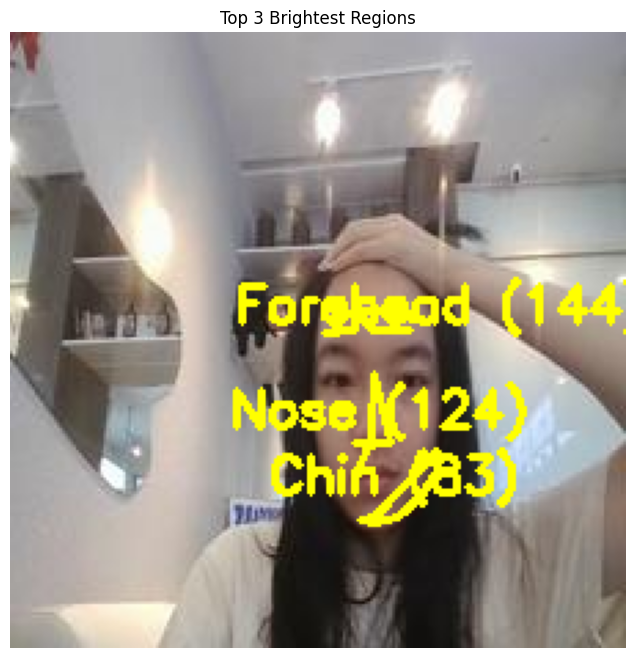

Top 3 Brightest Regions:
Forehead - Brightness: 144.1176470588235
Nose - Brightness: 124.40140845070422
Chin - Brightness: 83.00462962962962


In [6]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Load input image
image = cv2.imread(image01_path)  # Replace with your actual image path
h, w, _ = image.shape
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define facial regions with landmark indexes
FACIAL_REGIONS = {
    'Forehead': [10, 67, 69, 104, 108, 109, 151, 299, 337, 338, 297, 332],
    'Chin': [175, 148, 152, 377, 400, 378, 379, 365, 397, 288, 435, 416, 433],
    'Left Cheek': [234, 93, 132, 58, 172, 136, 150],
    'Right Cheek': [454, 323, 361, 288, 397, 365, 379],
    'Nose': [1, 2, 98, 327, 168, 197, 195, 5, 4, 94, 96]
}

# Function to compute brightness of a facial region
def get_region_brightness(image, landmarks, region_indexes):
    points = []
    for idx in region_indexes:
        lm = landmarks[idx]
        x, y = int(lm.x * w), int(lm.y * h)
        points.append((x, y))

    # Create mask for the region
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(points)], 255)

    # Compute brightness (mean grayscale value)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = cv2.mean(gray, mask=mask)[0]

    return brightness, np.array(points)

# Run face mesh detection
results = face_mesh.process(rgb_image)

if results.multi_face_landmarks:
    face_landmarks = results.multi_face_landmarks[0].landmark

    # Store brightness info
    region_brightness_list = []

    # Step 1: Compute brightness for each region
    for region_name, landmark_indexes in FACIAL_REGIONS.items():
        brightness, region_points = get_region_brightness(image, face_landmarks, landmark_indexes)
        region_brightness_list.append({
            "name": region_name,
            "brightness": brightness,
            "points": region_points
        })

    # Step 2: Sort by brightness descending
    region_brightness_list.sort(key=lambda x: x["brightness"], reverse=True)

    # Step 3: Visualize top 3 brightest regions
    output_image = image.copy()
    for i, region in enumerate(region_brightness_list[:3]):
        name = region["name"]
        points = region["points"]
        brightness = region["brightness"]

        color = (0, 255, 255)  # Yellow for highlight
        cv2.polylines(output_image, [points], isClosed=True, color=color, thickness=2)
        center_x, center_y = np.mean(points, axis=0).astype(int)
        cv2.putText(output_image, f"{name} ({int(brightness)})", (center_x - 50, center_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Convert to RGB for display
    output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Show image directly in notebook
    plt.figure(figsize=(10, 8))
    plt.imshow(output_rgb)
    plt.axis('off')
    plt.title('Top 3 Brightest Regions')
    plt.show()

    # Export the top 3 brightest regions and their brightness to a file
    with open('top_3_brightest_regions.txt', 'w') as f:
        for region in region_brightness_list[:3]:
            f.write(f"{region['name']} - Brightness: {region['brightness']}\n")
    
    # Optionally print out the top 3 regions to the console as well
    print("Top 3 Brightest Regions:")
    for region in region_brightness_list[:3]:
        print(f"{region['name']} - Brightness: {region['brightness']}")

else:
    print("No face detected in the image.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: normal
--- Percentage ---
acne: 0.09%
normal: 99.91%
Severity Score: 100.09
Redness (mean a* above baseline): 144.47
Coverage: 0.02%


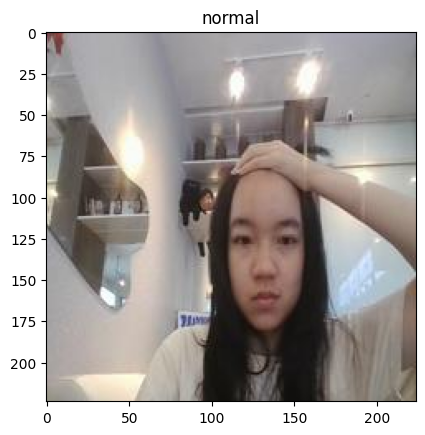

<Figure size 640x480 with 0 Axes>

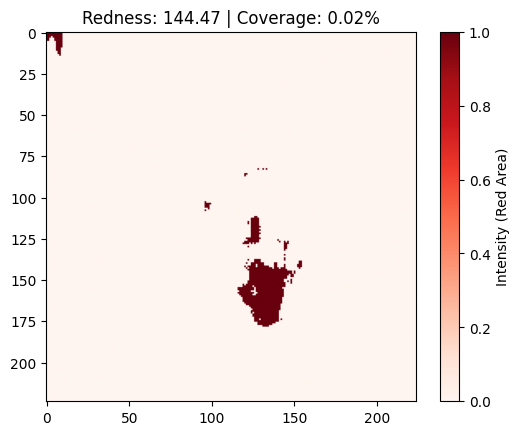

In [8]:
# Load model
model_acne_path = 'C:/Skin_Type_Classification-Recommendation/training_model_ipynb/keras_models/mobilenetv2_skin_classify_acne.keras'
model_acne = tf.keras.models.load_model(model_acne_path)

# Load and preprocess image
img_acne = load_img(image01_path, target_size=(resize, resize))
img_acne_array = img_to_array(img_acne)
img_acne_array = preprocess_input(img_acne_array.reshape(1, resize, resize, 3))

# Predict class
predictions_acne = model_acne.predict(img_acne_array)
predicted_acne_class_index = np.argmax(predictions_acne)
class_acne_names = ['acne', 'normal']
predicted_acne_class = class_acne_names[predicted_acne_class_index]

print(f"Predicted Class: {predicted_acne_class}")
print("--- Percentage ---")
for i, class_acne_name in enumerate(class_acne_names):
    print(f"{class_acne_name}: {predictions_acne[0][i]*100:.2f}%")

plt.title(predicted_acne_class)
plt.imshow(img_acne)
plt.figure('image01')

# New function for improved redness & coverage calculation
def calculate_accurate_redness(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    L, a, b = cv2.split(lab)
    
    # Detect skin region using HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_skin = np.array([0, 20, 50])
    upper_skin = np.array([35, 255, 255])
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Calculate median a* value of normal skin
    normal_a_median = np.median(a[skin_mask > 0])

    # Mask regions that are significantly redder than normal skin
    redness_mask = (a - normal_a_median) > 10  

    # Remove overly bright (whiteheads) or dark areas (shadows)
    brightness_threshold = (L > 30) & (L < 220)
    redness_mask = redness_mask & brightness_threshold

    # Calculate redness and coverage
    redness = np.mean(a[redness_mask]) if np.any(redness_mask) else 0
    coverage = (np.sum(redness_mask) / np.sum(skin_mask)) * 100 if np.any(skin_mask) else 0

    return redness, coverage, redness_mask

# Compute redness & coverage
redness, coverage, redness_mask = calculate_accurate_redness(image01_path)

# Compute severity score
def calculate_severity(redness, coverage):
    severity_score = 0.3 * redness + 0.2 * redness * coverage + 3000 * coverage
    return severity_score

severity = calculate_severity(redness, coverage)

# Print results
print(f"Severity Score: {severity:.2f}")
print(f"Redness (mean a* above baseline): {redness:.2f}")
print(f"Coverage: {coverage:.2f}%")

# Display redness mask
plt.figure('Redness & Coverage')
plt.imshow(redness_mask, cmap='Reds')
plt.title(f'Redness: {redness:.2f} | Coverage: {coverage:.2f}%')
plt.colorbar(label='Intensity (Red Area)')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: normal
--- Percentage ---
blackspots: 22.70%
normal: 77.30%


<Figure size 640x480 with 0 Axes>

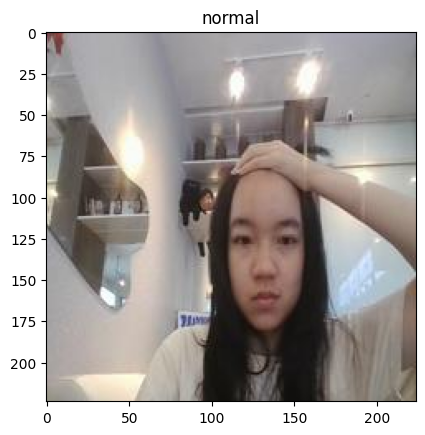

<Figure size 640x480 with 0 Axes>

In [9]:
# Load model
model_blackspot_path = 'C:/Skin_Type_Classification-Recommendation/training_model_ipynb/keras_models/mobilenetv2_skin_classify_blackspot.keras'
model_blackspot = tf.keras.models.load_model(model_blackspot_path)

# Load and preprocess image
img_blackspot = load_img(image01_path, target_size=(resize, resize))
img_blackspot_array = img_to_array(img_blackspot)
img_blackspot_array = preprocess_input(img_blackspot_array.reshape(1, resize, resize, 3))

# Predict class
predictions_blackspot = model_blackspot.predict(img_blackspot_array)
predicted_blackspot_class_index = np.argmax(predictions_blackspot)
class_blackspot_names = ['blackspots', 'normal']
predicted_blackspot_class = class_blackspot_names[predicted_blackspot_class_index]

print(f"Predicted Class: {predicted_blackspot_class}")
print("--- Percentage ---")
for i, class_blackspot_name in enumerate(class_blackspot_names):
    print(f"{class_blackspot_name}: {predictions_blackspot[0][i]*100:.2f}%")

plt.title(predicted_blackspot_class)
plt.imshow(img_blackspot)
plt.figure('image01')


In [10]:
import mediapipe as mp

# === Load Model === #
model_blackspot_path = 'C:/Skin_Type_Classification-Recommendation/training_model_ipynb/keras_models/mobilenetv2_skin_classify_blackspot.keras'
model_blackspot = tf.keras.models.load_model(model_blackspot_path)

# === Load original image === #
original_img = cv2.imread(image01_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
height, width, _ = original_img.shape

# === Face Landmark Detection for Preprocessing === #
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=1)
results = face_mesh.process(original_img)

if results.multi_face_landmarks:
    landmarks = results.multi_face_landmarks[0].landmark

    def get_landmark_points(landmark_ids):
        return np.array([[int(landmarks[i].x * width), int(landmarks[i].y * height)] for i in landmark_ids])

    FACEMESH_FACE_OVAL = [
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 
        378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 
        162, 21, 54, 103, 67, 109
    ]
    
    FACEMESH_LEFT_EYE = [33, 160, 158, 133, 153, 144, 145, 23, 243, 130, 243, 398]
    FACEMESH_RIGHT_EYE = [362, 385, 387, 263, 373, 380, 390, 373, 374, 382, 362, 263]
    FACEMESH_LIPS = [61, 185, 40, 39, 37, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375]
    FACEMESH_LEFT_BROW = [70, 63, 105, 66, 107, 55, 193, 122, 46]
    FACEMESH_RIGHT_BROW = [336, 296, 334, 293, 300, 285, 276, 353, 265]
    
    face_mask = np.zeros((height, width), dtype=np.uint8)
    face_region = cv2.convexHull(get_landmark_points(FACEMESH_FACE_OVAL))
    cv2.fillPoly(face_mask, [face_region], 255)
    
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_LEFT_EYE)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_RIGHT_EYE)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_LIPS)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_LEFT_BROW)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_RIGHT_BROW)], 0)
    
    filtered_img = original_img.copy()
    filtered_img[face_mask == 0] = [255, 255, 255]
else:
    print("⚠️ Cannot detect face, using original image!")
    filtered_img = original_img.copy()

# === Resize & Preprocess for Model === #
filtered_img_resized = cv2.resize(filtered_img, (resize, resize))
img_blackspot_array = img_to_array(filtered_img_resized)
img_blackspot_array = preprocess_input(img_blackspot_array.reshape(1, resize, resize, 3))

# === Convert to HSV using preprocessed image === #
hsv_img = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2HSV)

# Define HSV ranges for dark hyperpigmentation
dark_lower_brown = np.array([5, 30, 40])  
dark_upper_brown = np.array([30, 255, 180])  
dark_lower_red = np.array([0, 50, 50])    
dark_upper_red = np.array([15, 255, 180])

dark_mask_brown = cv2.inRange(hsv_img, dark_lower_brown, dark_upper_brown)
dark_mask_red = cv2.inRange(hsv_img, dark_lower_red, dark_upper_red)
dark_mask = cv2.bitwise_or(dark_mask_brown, dark_mask_red)

# Compute Darkness Level
darkness = np.mean(hsv_img[:, :, 2][dark_mask > 0])
print(f"Darkness Level: {darkness}")

# Compute Coverage Ratio
coverage = np.sum(dark_mask > 0) / np.sum(face_mask > 0)
print(f"Coverage Ratio: {coverage:.4f}")

# plt.figure(figsize=(6, 6))
# plt.imshow(filtered_img)
# plt.axis("off")
# plt.title("Preprocessed Image")
# plt.show()

Darkness Level: 135.49730146491905
Coverage Ratio: 0.8752


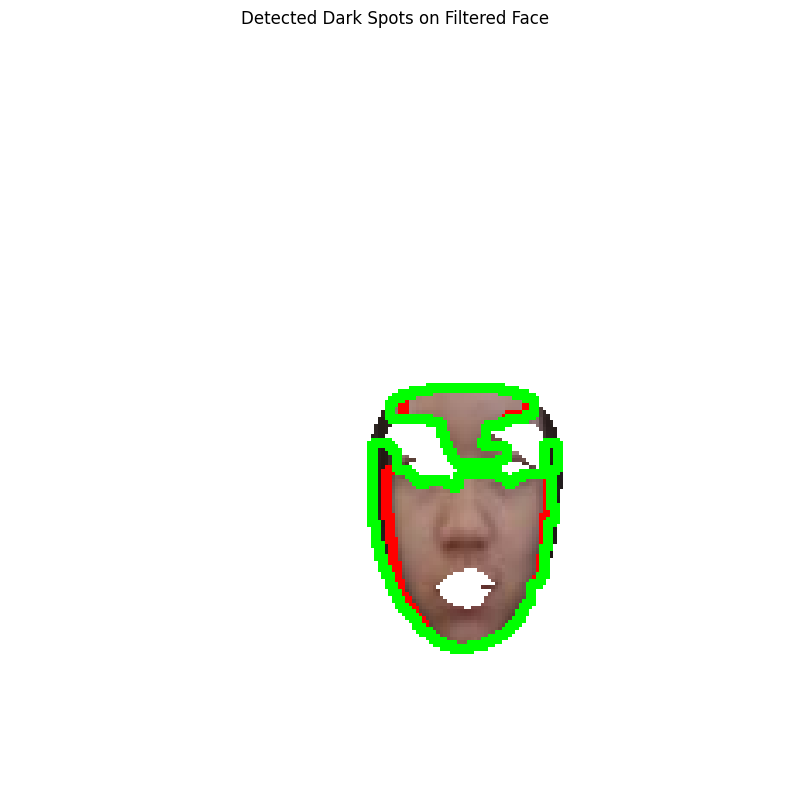

In [11]:
import mediapipe as mp

# === Load Model === #
model_blackspot_path = 'C:/Skin_Type_Classification-Recommendation/training_model_ipynb/keras_models/mobilenetv2_skin_classify_blackspot.keras'
model_blackspot = tf.keras.models.load_model(model_blackspot_path)

# === Load original image === #
original_img = cv2.imread(image01_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
height, width, _ = original_img.shape

# === Face Landmark Detection === #
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=1)
results = face_mesh.process(original_img)

if results.multi_face_landmarks:
    landmarks = results.multi_face_landmarks[0].landmark

    def get_landmark_points(landmark_ids):
        return np.array([[int(landmarks[i].x * width), int(landmarks[i].y * height)] for i in landmark_ids])

    # Define facial regions
    FACEMESH_FACE_OVAL = [
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 
        378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 
        162, 21, 54, 103, 67, 109
    ]

    FACEMESH_LEFT_EYE = [33, 160, 158, 133, 153, 144, 145, 23, 243, 130, 243, 398]
    FACEMESH_RIGHT_EYE = [362, 385, 387, 263, 373, 380, 390, 373, 374, 382, 362, 263]
    FACEMESH_LIPS = [61, 185, 40, 39, 37, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375]
    FACEMESH_LEFT_BROW = [70, 63, 105, 66, 107, 55, 193, 122, 46]
    FACEMESH_RIGHT_BROW = [336, 296, 334, 293, 300, 285, 276, 353, 265]

    # Generate masks
    face_mask = np.zeros((height, width), dtype=np.uint8)

    # Draw face oval
    face_region = cv2.convexHull(get_landmark_points(FACEMESH_FACE_OVAL))
    cv2.fillPoly(face_mask, [face_region], 255)

    # Remove eyes, lips, eyebrows
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_LEFT_EYE)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_RIGHT_EYE)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_LIPS)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_LEFT_BROW)], 0)
    cv2.fillPoly(face_mask, [get_landmark_points(FACEMESH_RIGHT_BROW)], 0)

    # Apply mask and convert non-face regions to WHITE
    filtered_img = original_img.copy()
    filtered_img[face_mask == 0] = [255, 255, 255]  # Chuyển vùng ngoài thành trắng
else:
    print("⚠️ Cannot detect face, using original image!")
    filtered_img = original_img.copy()

# === Resize & Preprocess for Model === #
filtered_img_resized = cv2.resize(filtered_img, (resize, resize))
img_blackspot_array = img_to_array(filtered_img_resized)
img_blackspot_array = preprocess_input(img_blackspot_array.reshape(1, resize, resize, 3))

# === Identify Dark Spots & Calculate Area === #
hsv_img = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2HSV)

# Define HSV ranges for dark hyperpigmentation
dark_lower_brown = np.array([5, 30, 40])  
dark_upper_brown = np.array([30, 255, 180])  
dark_lower_red = np.array([0, 50, 50])    
dark_upper_red = np.array([15, 255, 180])

dark_mask_brown = cv2.inRange(hsv_img, dark_lower_brown, dark_upper_brown)
dark_mask_red = cv2.inRange(hsv_img, dark_lower_red, dark_upper_red)
dark_mask = cv2.bitwise_or(dark_mask_brown, dark_mask_red)

# Define HSV ranges for lighter hyperpigmentation
light_lower_brown = np.array([3, 20, 30])  
light_upper_brown = np.array([35, 255, 190])  
light_lower_red = np.array([0, 40, 40])    
light_upper_red = np.array([20, 255, 200])

light_mask_brown = cv2.inRange(hsv_img, light_lower_brown, light_upper_brown)
light_mask_red = cv2.inRange(hsv_img, light_lower_red, light_upper_red)
light_mask = cv2.bitwise_or(light_mask_brown, light_mask_red)

# Apply morphological operations to remove noise
kernel = np.ones((3, 3), np.uint8)
dark_mask = cv2.morphologyEx(dark_mask, cv2.MORPH_OPEN, kernel, iterations=2)
light_mask = cv2.morphologyEx(light_mask, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours for dark spots
dark_contours, _ = cv2.findContours(dark_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
dark_filtered_contours = [cnt for cnt in dark_contours if 30 < cv2.contourArea(cnt) < 5000]

# Find contours for light spots
light_contours, _ = cv2.findContours(light_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
light_filtered_contours = [cnt for cnt in light_contours if 30 < cv2.contourArea(cnt) < 5000]

output_img = original_img.copy()
cv2.drawContours(output_img, dark_filtered_contours, -1, (255, 0, 0), 2)  # Blue for dark spots
cv2.drawContours(output_img, light_filtered_contours, -1, (0, 255, 0), 2)  # Green for light spots

# # Compute Darkness Level
# combined_mask = cv2.bitwise_or(dark_mask, light_mask)
# darkness = np.mean(hsv_img[:, :, 2][combined_mask > 0])

# print(f"Darkness Level: {darkness}")

# # Compute Coverage Ratio
# coverage = np.sum(mask > 0) / np.sum(face_mask > 0)
# print(f"Coverage Ratio: {coverage:.4f}")

output_img = filtered_img.copy()  
cv2.drawContours(output_img, dark_filtered_contours, -1, (255, 0, 0), 2)  # Blue for dark spots
cv2.drawContours(output_img, light_filtered_contours, -1, (0, 255, 0), 2)  # Green for light spots

# === Display Results === #
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.axis("off")
plt.title("Detected Dark Spots on Filtered Face")  
plt.show()